In [16]:

import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2, activationfn='tanh',):
        super(SentimentRNN, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout, 
            nonlinearity=activationfn, 
            bias=True
            )
    
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # Inside your model's forward method:
    def forward(self, x, mask):
        # Pack the padded sequence
        lengths = mask.sum(dim=1).int()  # Compute the lengths of the sequences (number of non-padded elements)
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass through the RNN
        packed_out, hidden = self.rnn(packed_x)
        
        # Unpack the sequence
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        
        # Perform mean pooling only over the valid (non-padded) parts
        out = (out * mask.unsqueeze(2)).sum(dim=1) / mask.sum(dim=1, keepdim=True)  # Mean pooling
        out = self.fc(out)  # Pass through the fully connected layer
        
        return out



In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        embeddings = [self.word2vec[word] for word in tokens if word in self.word2vec]
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        if len(embeddings) == 0:
            return self.__getitem__((idx + 1) % len(self.dataset))  # Skip empty sequences
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    '''Creates mini-batch tensors from the list of tuples (embeddings, labels, mask).'''
    
    embedding_dim = batch[0][0].size(1)
    
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
        

    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True) # (B, L, D)
    
    # Create the mask
    mask = (embeddings.sum(dim=2) != 0).float() # (B, L) - 1 if there is a word, 0 if it's a padding
    
    labels = torch.stack(labels)
    
    return embeddings, labels, mask


In [ ]:

from datasets import load_from_disk
import gensim.downloader as api

# Download the pre-trained Word2Vec model
# NOTE TO DHANISH: PLEASE SAVE THIS DATASET SINCE IT TAKES A LONG TIME TO DOWNLOAD
word2vec_model = api.load("word2vec-google-news-300") 



# This is the training dataset
path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=48, shuffle=True, collate_fn=collate_fn)

# Get the same for test and validation
path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=48, shuffle=False, collate_fn=collate_fn)

path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)
val_data = SentimentDataset(val_dataset, word2vec_model)
val_loader = DataLoader(val_data, batch_size=48, shuffle=False, collate_fn=collate_fn)


In [1]:
# Define model parameters
input_size = word2vec_model.vector_size         # Dimension of Word2Vec embeddings
hidden_size = 96        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
num_layers = 2           # Number of stacked RNN layers
dropout = 0.60        # Dropout rate for regularization


NameError: name 'word2vec_model' is not defined

In [30]:
def validate_model(model, val_loader, device, criterion, val_losses=[], val_accuracies=[]):
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for val_embeddings, val_labels, mask in val_loader:
            val_embeddings, val_labels, mask = val_embeddings.to(device), val_labels.to(device), mask.to(device)
            val_outputs = model(val_embeddings, mask).squeeze()
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_labels.size(0)  # Multiply by batch size for total loss
            val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()  # Threshold at 0.5
            val_correct_predictions += (val_predictions == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    
    # Store validation metrics for plotting
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    

Epoch 1/100, Loss: 0.5625, Accuracy: 0.7006 Validation Accuracy: 0.7205
Epoch 2/100, Loss: 0.4938, Accuracy: 0.7594 Validation Accuracy: 0.7645
Epoch 3/100, Loss: 0.4797, Accuracy: 0.7661 Validation Accuracy: 0.7664
Epoch 4/100, Loss: 0.4693, Accuracy: 0.7736 Validation Accuracy: 0.7580
Epoch 5/100, Loss: 0.4637, Accuracy: 0.7788 Validation Accuracy: 0.7814
Epoch 6/100, Loss: 0.4553, Accuracy: 0.7836 Validation Accuracy: 0.7636
Epoch 7/100, Loss: 0.4495, Accuracy: 0.7878 Validation Accuracy: 0.7674
Epoch 8/100, Loss: 0.4474, Accuracy: 0.7875 Validation Accuracy: 0.7852
Epoch 9/100, Loss: 0.4366, Accuracy: 0.7906 Validation Accuracy: 0.7833
Epoch 10/100, Loss: 0.4284, Accuracy: 0.8019 Validation Accuracy: 0.7758
Epoch 11/100, Loss: 0.4261, Accuracy: 0.8020 Validation Accuracy: 0.7589
Epoch 12/100, Loss: 0.4141, Accuracy: 0.8089 Validation Accuracy: 0.7655
Early stopping


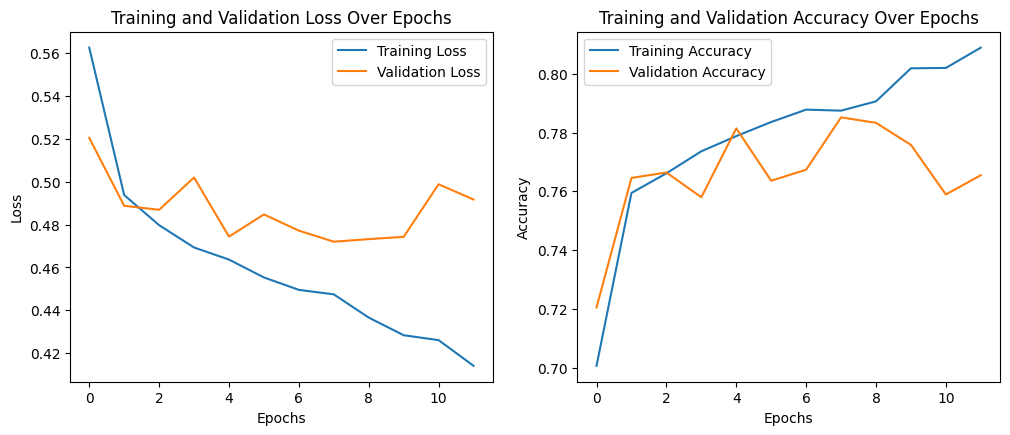

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 0.0001

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)


# Training parameters
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Set the model to training mode
    model.train()
    for embeddings, labels, mask in train_loader:
        # Move data to the same device as model (GPU if available)
        embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings, mask).squeeze()
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print the gradients
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", end=" ")
    validate_model(
        model,
        val_loader,
        device,
        criterion,
        val_losses,
        val_accuracies
    )
    # Early stopping: if the moving average validation accuracy has decreased, then stop
    if epoch > 10 and val_accuracies[-1] < np.mean(val_accuracies[-10:-1]):
        print("Early stopping")
        break 
        
    
# Save the model
torch.save(model.state_dict(), 'sentiment_rnn_2hl_64_055_0006.pth')

# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


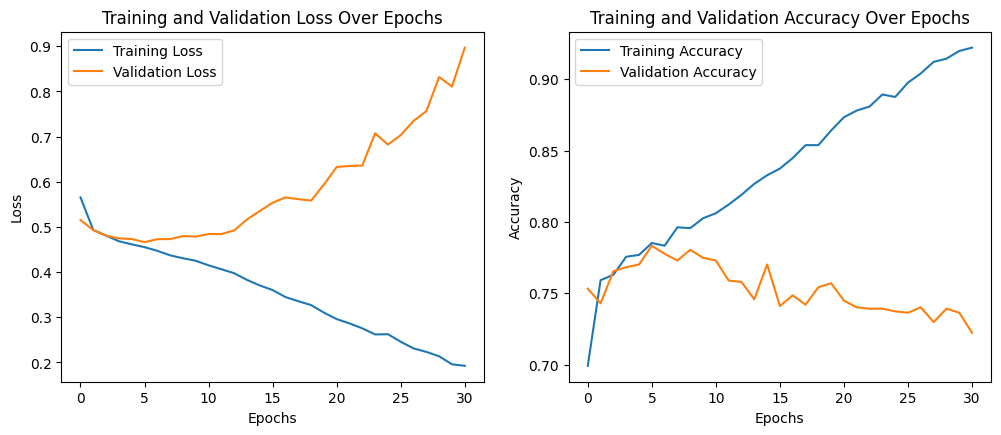

In [28]:
# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [ ]:
# Save the model
# torch.save(model.state_dict(), 'sentiment_rnn_2hl_196_0003.pth')

#load the model
# model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to('cuda')
# model.load_state_dict(torch.load('sentiment_rnn_2hl_196_0003.pth'))


/tmp/ipykernel_36228/3201192879.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sentiment_rnn_2hl_196_0003.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'sentiment_rnn_2hl_196_0003.pth'

In [ ]:
from datasets import load_from_disk
from gensim.models import Word2Vec


# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This is the word2vec model
word2vec_model = Word2Vec.load('word2vec.model')

# Load the validation and test datasets
path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)

path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)

# Test the model on the validation set
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_targets = []

for embeddings, labels, mask in test_loader:
    # Move data to the same device as model
    embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
    
    # Forward pass
    outputs = model(embeddings, mask).squeeze()
    
    # Store the actual and predicted labels
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    test_predictions.extend(predictions.tolist())
    test_targets.extend(labels.tolist())
    
# Calculate the test accuracy
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_accuracy = np.mean(test_predictions == test_targets)

print(f"testidation Accuracy: {test_accuracy:.4f}")